### The Machine Learning Algorithms

[1. Naive Bayes](#1)

[2. K-nearest Neighbors (kNN)](#2)

[3. Decision Tree Classifier](#3)

[4. Random Forest](#4)

In [2]:
#importing the libaries needed for model traning and testing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
import math 
import pydotplus
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn import preprocessing, linear_model, metrics
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image 
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
warnings.filterwarnings('ignore')


### Enconding categorical variables (Date, WindDir3pm, etc.)

In [12]:
AusWeather = pd.read_csv('data/cleaned_data.csv')
AusWeather = AusWeather.drop(columns=["Unnamed: 0"])

# Date
AusWeather['Date'] = pd.to_datetime(AusWeather['Date'])
# Add 3 more columns: Day, Month and Year
AusWeather.insert(1, 'Year', AusWeather['Date'].dt.year)
AusWeather.insert(1, 'Month', AusWeather['Date'].dt.month)
AusWeather.insert(1, 'Day', AusWeather['Date'].dt.day)
AusWeather.drop(columns=['Date'], axis=1, inplace=True)

# The remaining categorical columns
rain_tomorrow = AusWeather.iloc[:,-1]
risk_mm = AusWeather.iloc[:,-2]
re_columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm','RainToday']
AusWeather = pd.get_dummies(AusWeather, columns=re_columns)
AusWeather.drop(columns=['RISK_MM', 'RainTomorrow'], axis=1, inplace=True)
AusWeather['RISK_MM'] = risk_mm
AusWeather['RainTomorrow'] = rain_tomorrow
AusWeather.columns

Index(['Day', 'Month', 'Year', 'MinTemp', 'MaxTemp', 'Rainfall',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       ...
       'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W',
       'WindDir3pm_WNW', 'WindDir3pm_WSW', 'RainToday_No', 'RainToday_Yes',
       'RISK_MM', 'RainTomorrow'],
      dtype='object', length=116)

## 1. Naive Bayes<a id="1"></a>

In [56]:
# For all categrical variables
data = AusWeather.copy()
X = data.iloc[:, 15:-2]
y = data.iloc[:, -1]
y.replace({'No': 0, 'Yes': 1},inplace = True)
X

,Location_Adelaide,Location_Albany,Location_Albury,Location_Alice Springs,Location_Badgerys Creek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_No,RainToday_Yes
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
142189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
142190,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
142191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [57]:
# Split data into training and test set with 80% and 20% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Create a Gaussian Classifier  model
gnb = GaussianNB()

# Fit the model to training set
model = gnb.fit(X_train, y_train)

# Predictions
y_predict = gnb.predict(X_test)

In [58]:
print('The accuracy score of model: {:.3f}'.format(metrics.accuracy_score(y_test, y_predict)))
print('The accuracy score of training set: {:.4f}'.format(gnb.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(gnb.score(X_test, y_test)))

The accuracy score of model: 0.577
The accuracy score of training set: 0.5773
The accuracy score of testing set: 0.5773


### Conclusion

In [132]:
"""
The accuracy score are low, so it do not perform well to decide
whether it will rain tomorrow or not. In other words, it can 
predict on tomorrow weather less accurately
"""
print("Go next")

Go next


## 2. K-nearest Neighbors (kNN)<a id="2"></a>

In [60]:
data = AusWeather.copy()
X = data.iloc[:, 3:15]
y = data.iloc[:, -1]
y.replace({'No': 0, 'Yes': 1},inplace = True)

# Scale the range of X down to [0,1]
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

# Split data into training and test set with 80% and 20% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
0,0.534031,0.492958,0.021739,0.513514,0.512821,0.545455,0.670455,0.22,0.773110,0.789666,0.497423,0.503614
1,0.376963,0.544601,0.000000,0.513514,0.102564,0.500000,0.363636,0.25,0.794199,0.794708,0.505155,0.563855
2,0.520942,0.558685,0.000000,0.540541,0.487179,0.590909,0.295455,0.30,0.772383,0.801191,0.603093,0.537349
3,0.424084,0.612676,0.000000,0.243243,0.282051,0.204545,0.375000,0.16,0.845104,0.830724,0.528351,0.616867
4,0.641361,0.713615,0.036232,0.472973,0.179487,0.454545,0.795455,0.33,0.795654,0.781742,0.520619,0.693976
...,...,...,...,...,...,...,...,...,...,...,...,...
142188,0.274869,0.467136,0.000000,0.337838,0.384615,0.295455,0.534091,0.27,0.896736,0.891231,0.304124,0.481928
142189,0.256545,0.504695,0.000000,0.337838,0.333333,0.250000,0.443182,0.24,0.896009,0.884748,0.322165,0.518072
142190,0.277487,0.549296,0.000000,0.216216,0.333333,0.204545,0.500000,0.21,0.888010,0.876105,0.342784,0.568675
142191,0.324607,0.586854,0.000000,0.418919,0.230769,0.204545,0.465909,0.24,0.869829,0.859537,0.384021,0.607229


### k = 5

In [13]:
# Create a kNN model with k = 5
knn = KNeighborsClassifier(5 ,weights='uniform')

# Fit the model to training set
model = knn.fit(X_train, y_train)

# Predictions
y_predict = knn.predict(X_test)

# Accuracy Score 
print('The accuracy score of training set: {:.4f}'.format(knn.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(knn.score(X_test, y_test)))

The accuracy score of training set: 0.8747
The accuracy score of testing set: 0.8328


### k = 21

In [20]:
# Create a kNN model with k = 21
knn = KNeighborsClassifier(21 ,weights='uniform')

# Fit the model to training set
model = knn.fit(X_train, y_train)

# Predictions
y_predict = knn.predict(X_test)

# Accuracy Score 
print('The accuracy score of training set: {:.4f}'.format(knn.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(knn.score(X_test, y_test)))

The accuracy score of training set: 0.8539
The accuracy score of testing set: 0.8451


 ### k takes odd values from 1 to 100

In [41]:
k_range = range(1,101,2)
# Apply 10-fold cross-valation for every single value in k_range and
# return training scores and test scores
train_scores, test_scores = validation_curve(knn, X_train, y_train, 
                                              param_name="n_neighbors", 
                                              param_range=k_range,
                                              cv=10, scoring="accuracy")

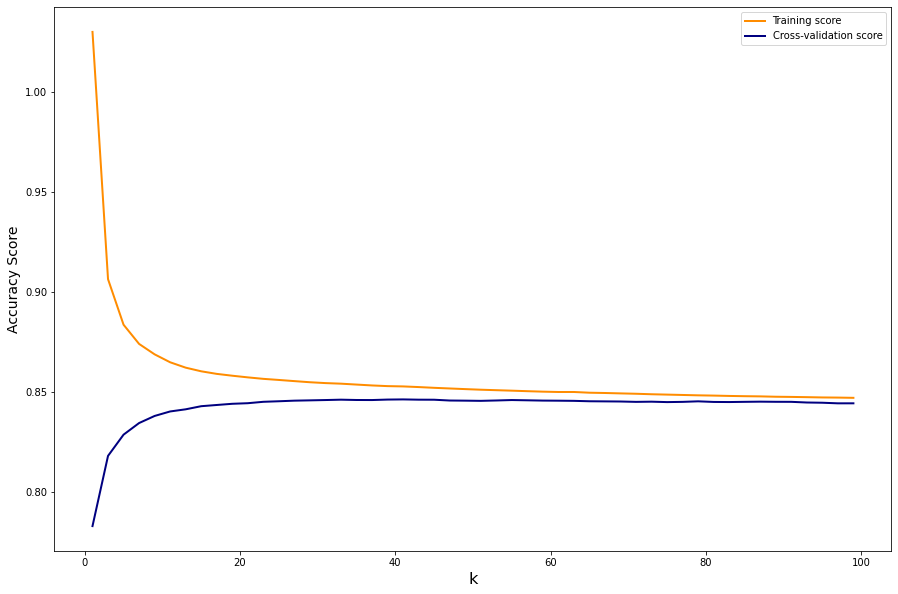

In [65]:
fig, ax = plt.subplots(figsize=(15,10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

ax.plot(k_range, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
ax.plot(k_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=2)
ax.set_xlabel("k", fontsize=16)
ax.set_ylabel("Accuracy Score", fontsize=14)
ax.legend(loc="best")
# fig.savefig("img/kNNScores.pdf")

In [56]:
"""
The line of training score experienced the downward trend while 
the cross-validation line witnessed the upward trend. These lines 
intend to intersection as the n_neighbors value increment. If k runs 
from 0 to around 20, the model is overffiting, because the training scores
are good but the cross-validation scores are poor.
"""
print("Go next")

Go next


In [61]:
# Create a kNN model with k = 99
knn = KNeighborsClassifier(99 ,weights='uniform')

# Fit the model to training set
model = knn.fit(X_train, y_train)

# Predictions
y_predict = knn.predict(X_test)

# Accuracy Score 
print('The accuracy score of training set: {:.4f}'.format(knn.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(knn.score(X_test, y_test)))

The accuracy score of training set: 0.8447
The accuracy score of testing set: 0.8443


### Conclusion

In [77]:
"""
Overall, the accuracy score is high, even though it tooks
quite a long time to train the model, so the K-nearest Neighbors 
model is good at predicting if it will rain tomorrow in Australia
"""
print("Go next")

Go next


### Try with dimensionality reduction PCA

In [62]:
data = AusWeather.copy()
X = data.iloc[:, 3:15]
y = data.iloc[:, -1]
y.replace({'No': 0, 'Yes': 1},inplace = True)

# Scale the range of X down to [0,1]
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

# Reduce big dimensions to 3 dimensions
pca = PCA(3)
X = pca.fit_transform(X)

# Split data into training and test set with 80% and 20% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X

array([[ 0.16747511, -0.02149809,  0.11782784],
       [ 0.20722145,  0.02057427, -0.18273998],
       [ 0.39210701, -0.00247471,  0.1222302 ],
       ...,
       [ 0.03993647, -0.10974212, -0.35557935],
       [ 0.11214705, -0.06535716, -0.32714517],
       [ 0.16189862, -0.05130589, -0.34455464]])

In [63]:
# Create a kNN model with k = 99
knn = KNeighborsClassifier(99 ,weights='uniform')

# Fit the model to training set
model = knn.fit(X_train, y_train)

# Predictions
y_predict = knn.predict(X_test)

# Accuracy Score 
print('The accuracy score of training set: {:.4f}'.format(knn.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(knn.score(X_test, y_test)))

The accuracy score of training set: 0.8175
The accuracy score of testing set: 0.8176


In [66]:
"""
The dataset was applied PCA to reduce its dimension to train model 
faster, but the model were less accurate and the difference between the
train-set and test-set scores was bigger, which indicates overfitting 
Therefore, there is no need to use PCA, but in comparison of training speed,
PCA-applied dataset was trained faster. 
"""
print("Go next")

Go next


## 3. Decision Tree Classifier<a id="3"></a>

In [14]:
data = AusWeather.copy()
X = data.iloc[:, 0:-2]
y = data.iloc[:, -1]

# Scale the range of X down to [0,1]
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

# Split data into training and test set with 80% and 20% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X

,Day,Month,Year,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_No,RainToday_Yes
0,0.000000,1.000000,0.1,0.534031,0.492958,0.021739,0.513514,0.512821,0.545455,0.670455,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.033333,1.000000,0.1,0.376963,0.544601,0.000000,0.513514,0.102564,0.500000,0.363636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.066667,1.000000,0.1,0.520942,0.558685,0.000000,0.540541,0.487179,0.590909,0.295455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.100000,1.000000,0.1,0.424084,0.612676,0.000000,0.243243,0.282051,0.204545,0.375000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.133333,1.000000,0.1,0.641361,0.713615,0.036232,0.472973,0.179487,0.454545,0.795455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,0.633333,0.454545,1.0,0.274869,0.467136,0.000000,0.337838,0.384615,0.295455,0.534091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
142189,0.666667,0.454545,1.0,0.256545,0.504695,0.000000,0.337838,0.333333,0.250000,0.443182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
142190,0.700000,0.454545,1.0,0.277487,0.549296,0.000000,0.216216,0.333333,0.204545,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
142191,0.733333,0.454545,1.0,0.324607,0.586854,0.000000,0.418919,0.230769,0.204545,0.465909,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [19]:
# Create a decision tree model with max_depth=5
DTree = DecisionTreeClassifier(max_depth=5, random_state=1, criterion="entropy")

# Fit the model to training set
model = DTree.fit(X_train, y_train)

# Predictions
y_predict = DTree.predict(X_test)

# Accuracy Score 
print('The accuracy score of training set: {:.4f}'.format(DTree.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(DTree.score(X_test, y_test)))

The accuracy score of training set: 0.8534
The accuracy score of testing set: 0.8561


### Find the best max_depth in range bewteen 1 and 30

In [26]:
depth_range = range(1,30)
# Apply 10-fold cross-valation for every single value in depth_range and
# return training scores and test scores
train_scores, test_scores = validation_curve(DTree, X_train, y_train, 
                                              param_name="max_depth", 
                                              param_range=depth_range,
                                              cv=10, scoring="accuracy")

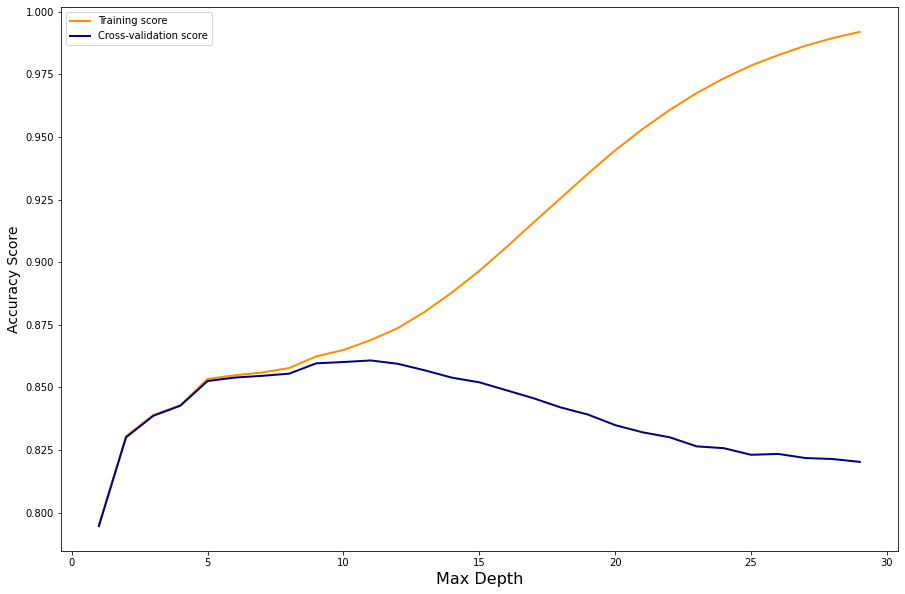

In [57]:
fig, ax = plt.subplots(figsize=(15,10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

ax.plot(depth_range, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
ax.plot(depth_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=2)
ax.set_xlabel("Max Depth", fontsize=16)
ax.set_ylabel("Accuracy Score", fontsize=14)
ax.legend(loc="best")
# fig.savefig("img/ScoreInDecisionTree.pdf")

In [73]:
"""
When the value of max_depth is below around 5 
as both training score and validation score are low, the model is underfitting. 
When these max_depth are too high above 10, the model become overfitting 
because two lines have their own intention in different directions, whichs
the validation score is poor and the testing score is good.
"""
print("Go next")

Go next


### max_depth = 8

In [59]:
# Create a decision tree model with max_depth=8
DTree = DecisionTreeClassifier(max_depth=8, random_state=1, criterion="entropy")

# Fit the model to training set
model = DTree.fit(X_train, y_train)

# Predictions
y_predict = DTree.predict(X_test)

# Accuracy Score 
print('The accuracy score of training set: {:.4f}'.format(DTree.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(DTree.score(X_test, y_test)))

The accuracy score of training set: 0.8572
The accuracy score of testing set: 0.8596


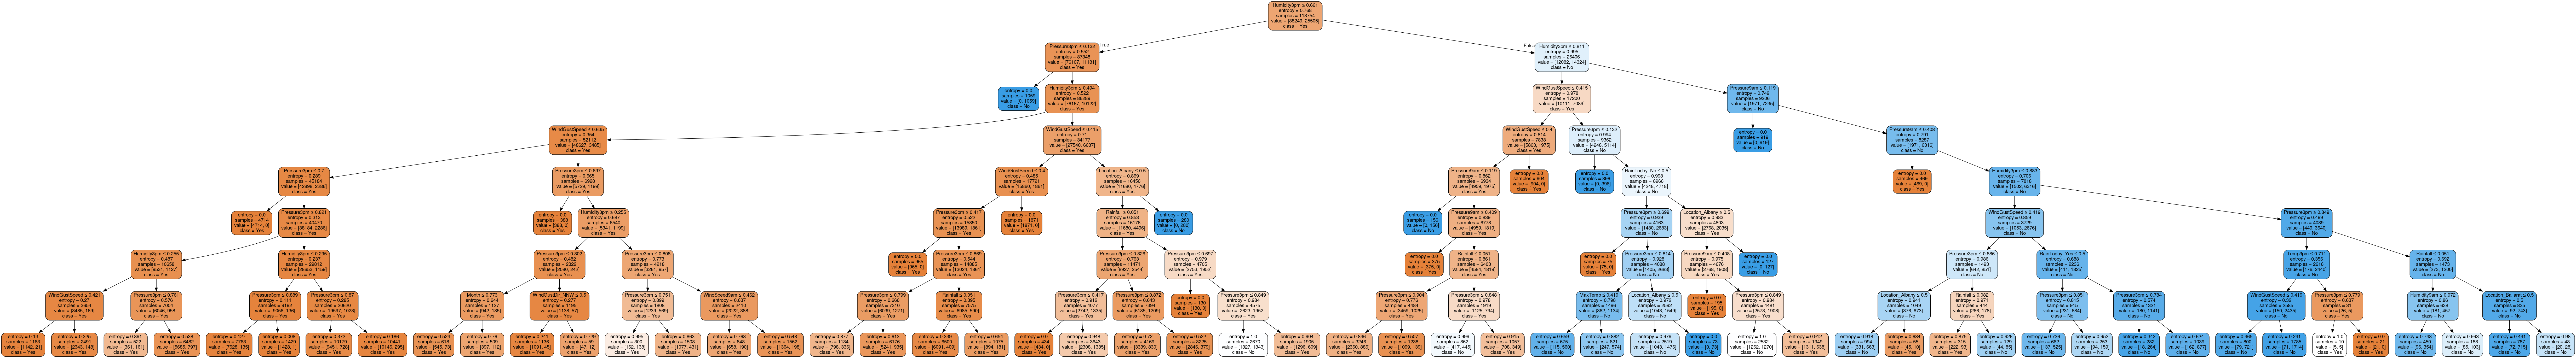

In [62]:
# Visualize tree
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,
               filled=True, rounded=True,
               special_characters=True,
                feature_names=X.columns, 
                class_names=["Yes", "No"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("img/DeCisionTree.pdf")
Image(graph.create_png())
# Go to "img" folder in the current directory
# to see the Tree graph more clearly 

### Try with dimensionality reduction PCA

In [71]:
data = AusWeather.copy()
X = data.iloc[:, 0:-2]
y = data.iloc[:, -1]

# Scale the range of X down to [0,1]
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

# Reduce big dimensions to 3 dimensions
pca = PCA(3)
X = pca.fit_transform(X)

# Split data into training and test set with 80% and 20% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X

array([[-0.23931988,  0.57459381, -0.01098545],
       [-0.34198186,  0.51881258,  0.06415912],
       [-0.2942706 ,  0.40199652, -0.16832415],
       ...,
       [-0.45957734,  0.05089445,  0.14838717],
       [-0.44238748,  0.0798547 ,  0.22890311],
       [-0.46409487, -0.30686001, -0.04156996]])

In [74]:
# Create a decision tree model with max_depth=5
DTree = DecisionTreeClassifier(max_depth=8, random_state=1, criterion="entropy")

# Fit the model to training set
model = DTree.fit(X_train, y_train)

# Predictions
y_predict = DTree.predict(X_test)

# Accuracy Score 
print('The accuracy score of training set: {:.4f}'.format(DTree.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(DTree.score(X_test, y_test)))

The accuracy score of training set: 0.8101
The accuracy score of testing set: 0.8048


In [79]:
"""
The dataset exprencing the PCA process leads to a faster process
of training model. However, it made the model return lower accuracy score,
and the quite larger difference bewteen train-set and test-set scores might
result in the state of overfitting or underfitting.
"""
print("Go next")

Go next


### Conclusion

In [80]:
"""
The Decision Tree Classifier model returns the high accuracy scores
in both test and training sets. Therefore, this model can predict accurately
the state of Australian tomorrow weather. 
"""
print("Go next")

Go next


## 4. Random Forest<a id="4"></a>

In [40]:
data = AusWeather.copy()
X = data.iloc[:, 3:-2]
y = data.iloc[:, -1]

# Scale the range of X down to [0,1]
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

# Reduce big dimensions to 3 dimensions
pca = PCA(3)
X = pca.fit_transform(X)

# Split data into training and test set with 80% and 20% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### n_estimators = 100

In [20]:
# Create a random forest with 100 desicison trees
RForest = RandomForestClassifier(n_estimators=100)

# Fit the model to training set
model = RForest.fit(X_train, y_train)

# Predictions
y_predict = RForest.predict(X_test)

# Accuracy Score 
print('The accuracy score of training set: {:.4f}'.format(RForest.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(RForest.score(X_test, y_test)))

The accuracy score of training set: 1.0000
The accuracy score of testing set: 0.8017


In [51]:
"""
The train-set accuracy score is perfecly 1, which makes a big disparity
in score from the testing accuracy score. Since train-set score is high and
oppositely test-set is low, the model become overfitting when dataset is sampled
into 100 random trees.
"""
print("Go next")

Go next


### Find the best n_estimators in range bewteen 1 and 50

In [21]:
### Find the best tree_range in range bewteen 1 and 30
tree_range = range(1,51,2)
# Apply 10-fold cross-valation for every single value in tree_range and
# return training scores and test scores
train_scores, test_scores = validation_curve(RForest, X_train, y_train, 
                                              param_name="n_estimators", 
                                              param_range=tree_range,
                                              cv=10, scoring="accuracy")

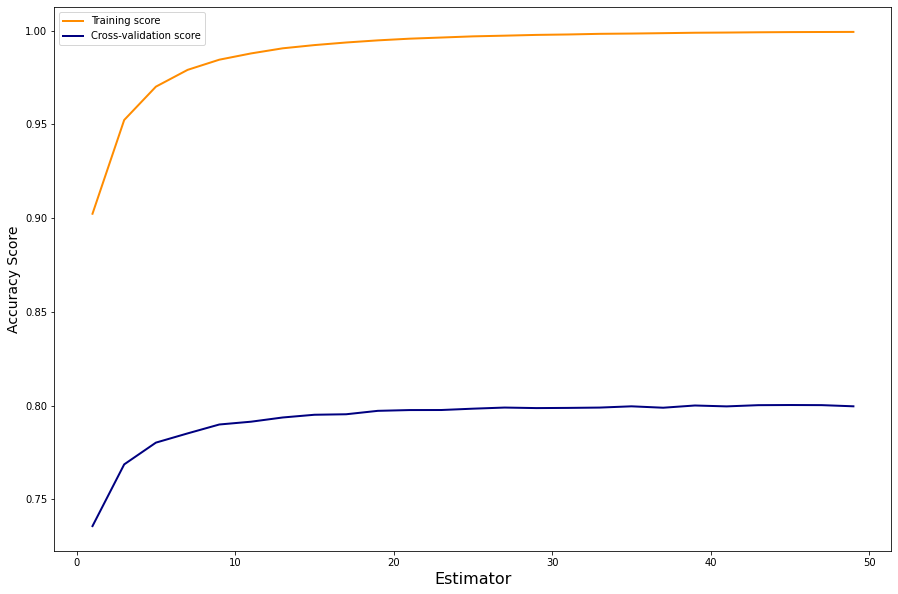

In [23]:
fig, ax = plt.subplots(figsize=(15,10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

ax.plot(tree_range, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
ax.plot(tree_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=2)
ax.set_xlabel("Estimator", fontsize=16)
ax.set_ylabel("Accuracy Score", fontsize=14)
ax.legend(loc="best")
# fig.savefig("img/RandomForest.pdf")

In [49]:
"""
The above graph show no intersection bewteen two lines of 
train-set score and test-set score, which means two lines seem to
experience parallel to each other over the range from 1 to possibly infinity
Therefore, to avoid less overfiting as possible, the forest consist of 
10 decision trees.
"""
print("Go next")

Go next


### n_estimators = 10

In [28]:
# Create a random forest with multiple 10 trees
RForest = RandomForestClassifier(n_estimators=10)

# Fit the model to training set
model = RForest.fit(X_train, y_train)

# Predictions
y_predict = RForest.predict(X_test)

# Accuracy Score 
print('The accuracy score of training set: {:.4f}'.format(RForest.score(X_train, y_train)))
print('The accuracy score of testing set: {:.4f}'.format(RForest.score(X_test, y_test)))

The accuracy score of training set: 0.9803
The accuracy score of testing set: 0.7962


In [50]:
"""
The Random Forest model on this dataset produce a potential state
of overfitting and return less accurate prediction. Therefore, using 
this model should be considered carefully. However, to return the optimal
performance, the Random Forest should be elemiated out of list of good models
for this dataset.
"""
print("End")

End
